In [ ]:
from mcp.server.fastmcp import FastMCP
from langchain.llms import OpenAI
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated

# -------------------------
# Step 1: Setup MCP Resource
# -------------------------
mcp = FastMCP("LangGraphMCPApp")

@mcp.resource("doc://ramayan")
def get_ramayan_doc():
    return (
        "The Ramayana is an ancient Indian epic that teaches dharma, "
        "devotion, righteousness, and the triumph of good over evil."
    )

# -------------------------
# Step 2: Define Graph State
# -------------------------
class GraphState(TypedDict):
    query: str
    context: str
    response: str

# -------------------------
# Step 3: MCP Tool Node
# -------------------------
def mcp_tool_node(state: GraphState) -> GraphState:
    query = state["query"]
    context = get_ramayan_doc()  # Direct call to MCP resource
    return {
        **state,
        "context": context,
    }

# -------------------------
# Step 4: LLM Node
# -------------------------
api_key = open("data/key.txt").read().strip()
llm = OpenAI(temperature=0.7, openai_api_key=api_key)

def llm_node(state: GraphState) -> GraphState:
    prompt = f"""Given the context:
{state['context']}

Answer the user query:
{state['query']}
"""
    response = llm(prompt)
    return {
        **state,
        "response": response
    }

# -------------------------
# Step 5: Define Graph Flow
# -------------------------
graph = StateGraph(GraphState)
graph.add_node("MCPTool", mcp_tool_node)
graph.add_node("LLM", llm_node)

graph.set_entry_point("MCPTool")
graph.add_edge("MCPTool", "LLM")
graph.add_edge("LLM", END)

runnable = graph.compile()

# -------------------------
# Step 6: Run it!
# -------------------------
output = runnable.invoke({"query": "What moral values does the Ramayana teach?"})
print(output["response"])


/tmp/ipykernel_109185/169950780.py:41: LangChainDeprecationWarning: The class `OpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAI``.
  llm = OpenAI(temperature=0.7, openai_api_key=api_key)
/tmp/ipykernel_109185/169950780.py:50: LangChainDeprecationWarning: The method `BaseLLM.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm(prompt)


[06/18/25 01:13:41] INFO     HTTP Request: POST https://api.openai.com/v1/completions "HTTP/1.1 200 ]8;id=436958;file:///home/avinash/Desktop/dr_avinash/generative_ai/lecture-8/torch/lib/python3.12/site-packages/httpx/_client.py\_client.py]8;;\:]8;id=699258;file:///home/avinash/Desktop/dr_avinash/generative_ai/lecture-8/torch/lib/python3.12/site-packages/httpx/_client.py#1025\1025]8;;\
                             OK"                                                                                   


The Ramayana teaches dharma, devotion, righteousness, and the triumph of good over evil as moral values.


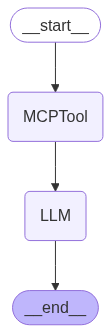

In [2]:
from IPython.display import Image, display

graph_image_data = runnable.get_graph().draw_mermaid_png()
display(Image(graph_image_data))